## Project: Analysing Currency Trends (based on Bitcoin, USD, GBP in relation to Euro).

***

### 1. Data Collection

***

Importing libraries.

In [1]:
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
import warnings
import logging
from fuctions import *
#from fuctions import flattenColumns

The Yahoo Finance API is known to have several limitations. Error messages returned by the API provide information on correctly fetching specific data. The most suitable data for the project was selected based on a particular time range and granularity. This selection was influenced by data availability and demand. Attempts to retrieve large volumes of data across different periods to expand the dataset were unsuccessful due to strict API limitations. The constraints dictate that data must be retrieved from today's date and are dependent on specific API parameters. Consequently, the data was broken into smaller chunks to prevent any loss of information.

A function was added to log any warnings that may occur during the execution of the script. This function logs warnings to a file, facilitating debugging in case any warnings arise.

In [2]:
warnings.showwarning = logWarning

Here is a few examples entry from the log file to help understand the syntax of the Yahoo Finance API interface:

```log File
YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "Invalid input - interval=50m is not supported. Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]")')

YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "15m data not available for startTime=1671481488 and endTime=1734553488. The requested range must be within the last 60 days.")')
```

***

Downloading exchange rate USD to EUR represented by USDEUR=X and GBP to EUR represented by GBPEUR=X.

In [3]:
# Download USD/EUR and GBP/EUR exchange rates
eur2yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='2y', interval='60m', group_by='ticker')
eur5yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5y', interval='1d', group_by='ticker')
eur5draw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5d', interval='5m', group_by='ticker')

eur5draw.head(2)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Ticker                    GBPEUR=X                                             \
Price                         Open     High     Low    Close Adj Close Volume   
Datetime                                                                        
2024-12-23 00:00:00+00:00  1.20467  1.20484  1.2044  1.20478   1.20478    0.0   
2024-12-23 00:05:00+00:00  1.20487  1.20496  1.2046  1.20493   1.20493    0.0   

Ticker                    USDEUR=X                                          
Price                         Open    High    Low   Close Adj Close Volume  
Datetime                                                                    
2024-12-23 00:00:00+00:00   0.9581  0.9581  0.958  0.9581    0.9581    0.0  
2024-12-23 00:05:00+00:00   0.9581  0.9581  0.958  0.9580    0.9580    0.0

Downloading exchange rate BTC to EUR represented by BTC-EUR.

In [4]:
# Download BTC-EUR data
btc2yraw = yf.download('BTC-EUR', period='2y', interval='60m')
btc5yraw = yf.download('BTC-EUR', period='5y', interval='1d')
btc5draw = yf.download('BTC-EUR', period='5d', interval='5m')

# For debugging purposes
btc2yraw.head(2)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Datetime,,,,,,
2022-12-29 00:00:00,15600.557617,15600.557617,15611.49707,15573.189453,15573.189453,0
2022-12-29 01:00:00,15575.709961,15575.709961,15606.46875,15570.717773,15602.501953,0


The data will be saved to separate CSV files, but before doing so, it will be formatted appropriately.

The sequence of columns is being changed first to ensure consistency with other DataFrames.

In [5]:
# Define the list of DataFrames
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Define the desired order for the columns
newOrder = [
    ('Open', 'BTC-EUR'), 
    ('High', 'BTC-EUR'), 
    ('Low', 'BTC-EUR'),
    ('Close', 'BTC-EUR'), 
    ('Adj Close', 'BTC-EUR'), 
    ('Volume', 'BTC-EUR')
]

# Reorder the columns for each DataFrame
formatedDataFrames = []

for df in dataframes:
    # Reorder the columns using the new_order
    formatedDf = df[newOrder]
    formatedDataFrames.append(formatedDf)

btc2yraw, btc5yraw, btc5draw = formatedDataFrames
# For degurging purposes
btc5yraw.head()


Price,Open,High,Low,Close,Adj Close,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Date,,,,,,
2019-12-28,6522.800781,6621.246094,6520.898438,6548.715820,6548.715820,19119692112
2019-12-29,6548.409180,6723.894531,6514.598633,6638.048340,6638.048340,20072704182
2019-12-30,6635.920410,6653.482422,6490.386719,6510.733887,6510.733887,20420606561
2019-12-31,6512.022949,6537.012207,6392.172363,6411.460449,6411.460449,18866418835
2020-01-01,6412.612793,6469.861816,6420.140137,6417.781738,6417.781738,16548264141


Next, multi-index columns will be flattened into single-level columns, and 'Date' will be renamed to 'Datetime' to ensure consistency with the other datasets.

In [6]:
## List of DataFrames for 2 years, 5 years, and 5 days data
all2y = [eur2yraw, btc2yraw]
all5y = [eur5yraw, btc5yraw]
all5d = [eur5draw, btc5draw]

# Reset index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.reset_index(inplace=True)  # Resets the index for each DataFrame

# Apply flatten_columns function to each DataFrame in all lists
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        flattenColumns(df)
        
# Setting index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.set_index('Datetime', inplace=True)

# For degurging purposes
btc2yraw.head()


,Open_BTC-EUR,High_BTC-EUR,Low_BTC-EUR,Close_BTC-EUR,Adj Close_BTC-EUR,Volume_BTC-EUR
Datetime,,,,,,
2022-12-29 00:00:00,15573.189453,15611.497070,15573.189453,15600.557617,15600.557617,0
2022-12-29 01:00:00,15602.501953,15606.468750,15570.717773,15575.709961,15575.709961,0
2022-12-29 02:00:00,15575.572266,15575.572266,15532.362305,15569.251953,15569.251953,231855104
2022-12-29 03:00:00,15570.788086,15593.959961,15568.463867,15593.629883,15593.629883,0
2022-12-29 04:00:00,15593.848633,15608.440430,15583.450195,15605.694336,15605.694336,0


Finally, the names of the existing columns are being changed.

In [ ]:
# Define the new order and column name mapping
rename_dict = {
    'Open_BTC-EUR': 'BTC-EUR_Open',
    'High_BTC-EUR': 'BTC-EUR_High',
    'Low_BTC-EUR': 'BTC-EUR_Low',
    'Close_BTC-EUR': 'BTC-EUR_Close',
    'Adj Close_BTC-EUR': 'BTC-EUR_Adj Close',
    'Volume_BTC-EUR': 'BTC-EUR_Volume'
}

# List of DataFrames to process
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Rename columns and reorder the columns for each DataFrame
for df in dataframes:
    # Rename columns to match newOrder
    df.rename(columns=rename_dict, inplace=True)

# For degurging purposes
btc2yraw.head(3)


,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume
Datetime,,,,,,
2022-12-29 00:00:00,15573.189453,15611.497070,15573.189453,15600.557617,15600.557617,0
2022-12-29 01:00:00,15602.501953,15606.468750,15570.717773,15575.709961,15575.709961,0
2022-12-29 02:00:00,15575.572266,15575.572266,15532.362305,15569.251953,15569.251953,231855104


Now is time to save the data.

In [8]:
# Save the data to CSV files
eurToSave = [eur2yraw, eur5yraw, eur5draw]
filenames = ['eur2yraw.csv', 'eur5yraw.csv', 'eur5draw.csv']
for i in range(3):
    eurToSave[i].to_csv(f'data/csv/raw/{filenames[i]}')
print('Data saved to CSV files.')

Data saved to CSV files.


In [9]:
# Save the data to CSV files
btcToSave = [btc2yraw, btc5yraw, btc5draw]
filenames = ['btc2yraw.csv', 'btc5yraw.csv', 'btc5draw.csv']
for i in range(3):
    btcToSave[i].to_csv(f'data/csv/raw/{filenames[i]}')
print('Data saved to CSV files.')


Data saved to CSV files.


***

#### Transferring to the Database.

An SQLite database named currency.db will be created. The data from the CSV files will then be inserted into the tables, with the data flattened to ensure compatibility with the database structure.

The CSV files will be transferred to the SQLite database. 

In [10]:
# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect('data/db/currencies.db')

# List of DataFrames and their corresponding table names
dataframes = [(eur2yraw, 'eur2yraw'), (eur5yraw, 'eur5yraw'), (eur5draw, 'eur5draw'), 
              (btc2yraw, 'btc2yraw'), (btc5yraw, 'btc5yraw'), (btc5draw, 'btc5draw')]
# Loop to write each DataFrame to the SQLite database
for df, table_name in dataframes:
    df.to_sql(table_name, conn, if_exists='replace', index=True)
    
# Close the connection to SQLite
conn.close()

print("Data successfully written to SQLite database.")


Data successfully written to SQLite database.


The contents of the database will be checked to identify the tables it contains.

In [11]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')
cursor = conn.cursor()

# Query to list tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the tables
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection
conn.close()

Tables in the database:
allCurrenciesData2y
allCurrenciesData5y
allCurrenciesData5d
normalisedBasedValue2y
normalisedBasedValue5y
normalisedBasedValue5d
normalisedMinMax2y
normalisedMinMax5y
normalisedMinMax5d
normalisedZscore2y
normalisedZscore5y
normalisedZscore5d
eur2yraw
eur5yraw
eur5draw
btc2yraw
btc5yraw
btc5draw


A test query will be executed on the database to check its functionality.

In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')

# Read data from the table into a pandas DataFrame
query = "SELECT * FROM btc5yraw LIMIT 5;"  # Adjust for your table name
df = pd.read_sql(query, conn)
df.set_index('Datetime', inplace=True)

# Display the DataFrame
df

,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume
Datetime,,,,,,
2019-12-28 00:00:00,6522.800781,6621.246094,6520.898438,6548.715820,6548.715820,19119692112
2019-12-29 00:00:00,6548.409180,6723.894531,6514.598633,6638.048340,6638.048340,20072704182
2019-12-30 00:00:00,6635.920410,6653.482422,6490.386719,6510.733887,6510.733887,20420606561
2019-12-31 00:00:00,6512.022949,6537.012207,6392.172363,6411.460449,6411.460449,18866418835
2020-01-01 00:00:00,6412.612793,6469.861816,6420.140137,6417.781738,6417.781738,16548264141


Understanding the collected data is essential. The following columns can be identified:
* Open: Price at the start of the trading period.
* High: Highest price during the trading period.
* Low: Lowest price during the trading period.
* Close: Price at the end of the trading period.
* Adj Close: Close price adjusted for events like splits or dividends (irrelevant in this case).
* Volume: Total amount of the asset traded during the period.


***

### 2. Data Cleaning

The choice was made to analyse OHLC data (Open, High, Low, Close), with the analysis focused on the Close price. This provides a comprehensive view of price movements, which is crucial for identifying market trends and making informed trading decisions.

Other data, such as volume or adjusted close, will be omitted, as they are less relevant for understanding price action and trend analysis. Upon examining the data, it became clear that the Adj Close column contains the same values as the Close column, and the Volume column is empty.

Formatting Data Frames for easier manipulation 

The columns not needed for the analysis were removed. The 'Adj Close' and 'Volume' columns will be removed from the DataFrames.

In [13]:
# Columns to drop (targeting columns that have '_Adj Close' or '_Volume' suffixes)
columnsToDrop = ['_Adj Close', '_Volume']

# List of DataFrames for each asset
dfColumnsDroppedList = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

# Iterate over each DataFrame and drop columns that contain '_Adj Close' or '_Volume'
for df in dfColumnsDroppedList:
    df.drop([col for col in df.columns if any(drop in col for drop in columnsToDrop)], axis=1, inplace=True)

# Verify the result (Optional)
eur2yraw.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close
Datetime,,,,,,,,
2022-12-28 00:00:00,0.9399,0.9409,0.9392,0.9406,1.13045,1.13079,1.1296,1.13074
2022-12-28 01:00:00,0.9406,0.9406,0.9391,0.9394,1.13091,1.13114,1.1297,1.12993
2022-12-28 02:00:00,0.9396,0.9399,0.9393,0.9399,1.12998,1.13021,1.1287,1.12899


It is ensured that there is no empty data in the datasets.

In [14]:
dataFrames = {
    "eur2yraw": eur2yraw,
    "btc2yraw": btc2yraw,
    "eur5yraw": eur5yraw,
    "btc5yraw": btc5yraw,
    "eur5draw": eur5draw,
    "btc5draw": btc5draw
}

# Find missing values in each DataFrame
for name, df in dataFrames.items():
    print(f'Empty values in {name}: {df.isnull().sum().sum()}')


Empty values in eur2yraw: 48
Empty values in btc2yraw: 0
Empty values in eur5yraw: 0
Empty values in btc5yraw: 0
Empty values in eur5draw: 88
Empty values in btc5draw: 0


Missing values are now filled using the forward fill method.

In [15]:
# List of DataFrames
dataFrames = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

# Forward fill missing values for each DataFrame in the list
for df in dataFrames:
    df.ffill(inplace=True)

The datetime format is being checked to ensure it is correct.

In [16]:
dataFrames = {
    "eur2yraw": eur2yraw,
    "btc2yraw": btc2yraw,
    "eur5yraw": eur5yraw,
    "btc5yraw": btc5yraw,
    "eur5draw": eur5draw,
    "btc5draw": btc5draw
}

for name, df in dataFrames.items():
    if pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S', errors='coerce').notnull().all():
        print(f"DataFrame '{name}': Index format is correct.")
    else:
        print(f"DataFrame '{name}': Index contains invalid formats.")


DataFrame 'eur2yraw': Index format is correct.
DataFrame 'btc2yraw': Index format is correct.
DataFrame 'eur5yraw': Index format is correct.
DataFrame 'btc5yraw': Index format is correct.
DataFrame 'eur5draw': Index format is correct.
DataFrame 'btc5draw': Index format is correct.


Since a merge will be performed, the DataFrames will be converted to the same time zone.

In [17]:
## Convert to the same timezone (UTC) if the index is already timezone-aware
dataFrames = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

for df in dataFrames:
    if df.index.tzinfo is None:  # If timezone is naive, localize to UTC
        df.index = df.index.tz_localize('UTC')
    else:  # If timezone is already aware, convert to UTC
        df.index = df.index.tz_convert('UTC')

The DataFrames with the exchange rates and the Bitcoin data will now be merged.

In [18]:
allCurrenciesData2y = eur2yraw.merge(btc2yraw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allCurrenciesData5y = eur5yraw.merge(btc5yraw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allCurrenciesData5d = eur5draw.merge(btc5draw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC')) 

The data is saved to CSV files for future use.

In [19]:
# Save merged data to CSV files
allCurrencies = {'allCurrenciesData2y': allCurrenciesData2y, 'allCurrenciesData5y': allCurrenciesData5y, 'allCurrenciesData5d': allCurrenciesData5d}
for name, df in allCurrencies.items():
    df.to_csv(f'data/csv/allcurrencies/{name}.csv')

The data is transferred to an SQLite database.

In [20]:
allCurrencies = {'allCurrenciesData2y': allCurrenciesData2y, 'allCurrenciesData5y': allCurrenciesData5y, 'allCurrenciesData5d': allCurrenciesData5d}
# Transfer the data to SQLite database
conn = sqlite3.connect('data/db/currencies.db')
for name, df in allCurrencies.items():
    df.to_sql(name, conn, if_exists='replace', index=True)
conn.close()


#### Normalise Bitcoin exchange rates

Normalisation is a technique used to adjust data to a consistent scale, enabling a more straightforward comparison of how values, such as prices, vary or change relative to one another.

Different normalisation techniques, such as Base Value Normalisation, Min-Max Normalisation, and Z-score Normalisation, have been used to demonstrate how normalisation can be performed. Since Bitcoin will be compared to other currencies, all the compared data must be normalised using the same method.

##### Indexing to a Base Value or Base Value Normalisation. 

This method expresses all data points as a percentage relative to the first value in the dataset.

The data was normalised using the Indexing to Base Value method.

In [21]:
# List of DataFrames to normalise
dataFrames = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueFrames = [df.div(df.iloc[0]).mul(100) for df in dataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValue2y, normalisedBasedValue5y, normalisedBasedValue5d = \
normalisedBasedValueFrames[0], normalisedBasedValueFrames[1], normalisedBasedValueFrames[2]
normalisedBasedValue5d.head(3)


,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2024-12-24 00:00:00+00:00,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-24 00:05:00+00:00,100.004988,99.999179,100.0,100.029065,100.010409,100.010401,100.020819,100.010401,99.924734,99.924734,99.941632,99.941632
2024-12-24 00:10:00+00:00,100.004157,99.999179,100.0,100.021591,100.010409,100.010401,100.020819,100.010401,99.791789,99.791789,99.673236,99.764459


This approach is widely used to standardise time-series data, making comparing trends across different datasets or variables easier. It is particularly useful in financial and economic contexts, such as analysing stock prices, cryptocurrency values, or economic indicators. 

Read more on the [Medium Website](https://medium.com/coinmonks/cryptocurrency-analysis-with-python-understanding-normalization-returns-rewards-and-risk-7e4d530c917).

##### Min-max Normalisation

Min-max normalisation is a widely used method to scale data. In this approach, the smallest value of a feature is mapped to 0, the largest value is mapped to 1, and all other values are scaled proportionally to lie within the range of 0 and 1.

In [22]:
# List of DataFrames
dataframes = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in dataFrames
]

# Unpack the normalized DataFrames
normalisedMinMax2y, normalisedMinMax5y, normalisedMinMax5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMax5y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2019-12-30 00:00:00+00:00,0.361936,0.339614,0.363203,0.362283,0.713173,0.627858,0.728747,0.713694,0.022278,0.018612,0.029148,0.021371
2019-12-31 00:00:00+00:00,0.354033,0.333047,0.356029,0.355397,0.712006,0.683151,0.734967,0.711948,0.020997,0.017427,0.028131,0.020345
2020-01-01 00:00:00+00:00,0.348419,0.347210,0.360485,0.349038,0.782577,0.717904,0.805969,0.783168,0.019968,0.016743,0.028421,0.020410


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Min-max normalization ensures that all features are scaled to the same range, typically between 0 and 1. Still, it is ineffective at managing outliers, as they can significantly skew the results. 

##### Z-score normalization


Z-score normalisation is a method that helps to avoid problems with outliers. If a value is the same as the mean of a feature, it is normalised to 0. If the value is below the mean, it becomes a negative number; if it is above the mean, it turns positive. 
The size of these negative and positive values is determined by how spread out the original data is based on its standard deviation. In simpler terms, if the original data points vary widely, the normalised values will be smaller. Conversely, the normalised values will be larger if the original data has less variation.


***

In [23]:
# List of DataFrames
dataframes = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in dataFrames
]

# Unpack the normalized DataFrames
normalisedZscore2y, normalisedZscore5y, normalisedZscore5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscore5y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2019-12-30 00:00:00+00:00,-0.213431,-0.272000,-0.223526,-0.214269,0.434505,0.467533,0.464841,0.433466,-1.355427,-1.361760,-1.354000,-1.361789
2019-12-31 00:00:00+00:00,-0.252179,-0.303947,-0.258115,-0.248051,0.428163,0.749580,0.499053,0.423953,-1.361893,-1.367697,-1.359247,-1.366961
2020-01-01 00:00:00+00:00,-0.279704,-0.235044,-0.236631,-0.279252,0.811496,0.926849,0.889540,0.811830,-1.367082,-1.371120,-1.357753,-1.366632


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Z-score normalisation handles outliers but does not scale data to a consistent range.

The normalised data is stored in CSV files to provide easy access to well-prepared Data Frames.

In [24]:
# Save the normalised data to CSV files
normalisedData = {
    'normalisedBasedValue2y': normalisedBasedValue2y,
    'normalisedBasedValue5y': normalisedBasedValue5y,
    'normalisedBasedValue5d': normalisedBasedValue5d,
    'normalisedMinMax2y': normalisedMinMax2y,
    'normalisedMinMax5y': normalisedMinMax5y,
    'normalisedMinMax5d': normalisedMinMax5d,
    'normalisedZscore2y': normalisedZscore2y,
    'normalisedZscore5y': normalisedZscore5y,
    'normalisedZscore5d': normalisedZscore5d
}

for name, df in normalisedData.items():
    df.to_csv(f'data/csv/normalised/{name}.csv')

The decision was also made to store the data in the database.

In [25]:
# Transfer the data to SQLite database
conn = sqlite3.connect('data/db/currencies.db')
for name, df in normalisedData.items():
    df.to_sql(name, conn, if_exists='replace', index=True)
conn.close()

***

### 3. Exploratory Data Analysis (EDA)

Three datasets, spanning 5 days, 2 years, and 5 years, and normalised using methods such as Base Value Normalisation, Min-Max Normalisation, and Z-score normalisation, are available. These will be used to present historical data through a line plot.

The process begins with creating a line plot for Base Value Normalisation.

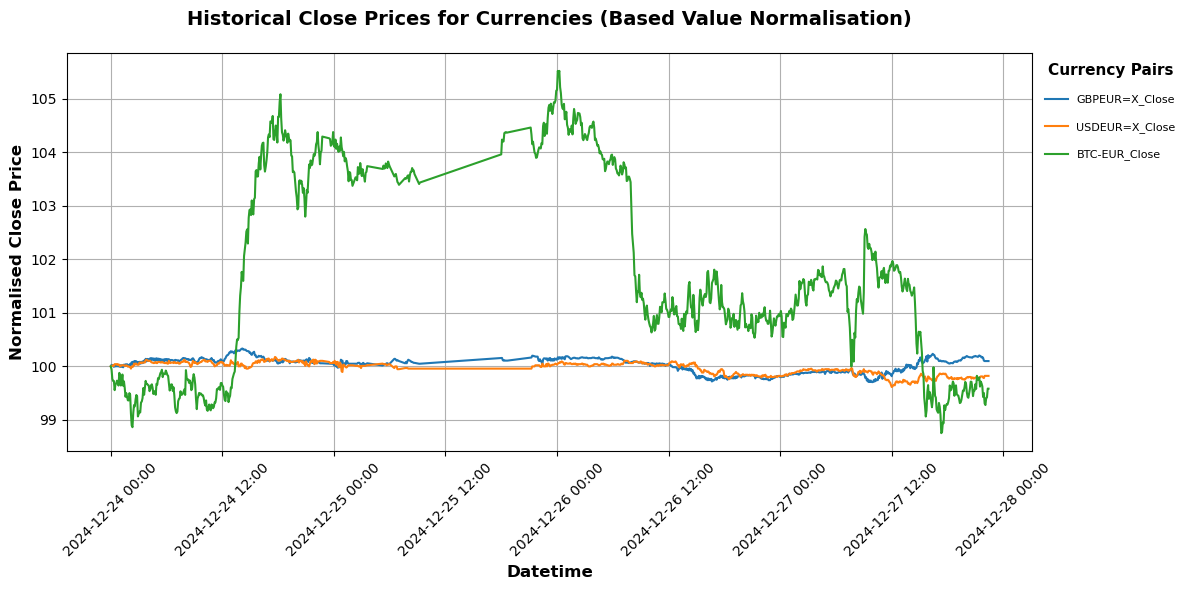

In [26]:
plotClosePrices(normalisedBasedValue5d, title='Historical Close Prices for Currencies (Based Value Normalisation)')

The British Pound (GBP) has shown a relatively stable trend against the Euro (EUR), with only minor fluctuations. This stability may reflect the overall economic steadiness of the UK and the Eurozone during this period, with no major disruptions or events significantly affecting the exchange rate.

Similarly, the USDEUR=X_Close, covering the past five days, demonstrates a normalised pattern similar to GBPEUR. This suggests that the USD has remained relatively stable against the Euro in the short term, likely indicating a lack of significant economic disturbances in both the US and the Eurozone.

In contrast, BTC-EUR_Close exhibits considerable volatility over the same five-day period, which is typical for Bitcoin and other cryptocurrencies. Such fluctuations are common due to the inherent volatility of cryptocurrencies, which are more susceptible to market sentiment and external influences.

In summary, the fiat currency pairs (GBPEUR and USDEUR) show a pattern of stability. In contrast, the BTC-EUR pair is more volatile, highlighting the contrasting nature of traditional currencies versus digital assets.

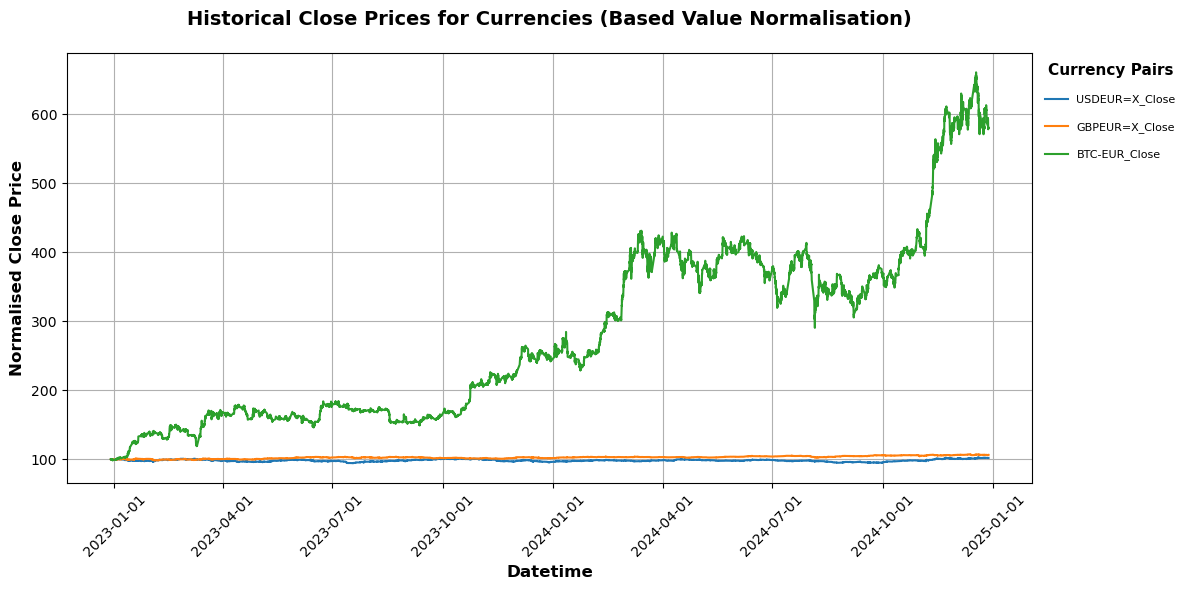

In [27]:
plotClosePrices(normalisedBasedValue2y, title='Historical Close Prices for Currencies (Based Value Normalisation)')

The USDEUR=X_Close, represented by the blue line, has remained relatively stable for the two years with only minor fluctuations around the base value 100. This stability indicates that the exchange rate between the USD and EUR has not seen any significant turmoil, signalling steady economic conditions in the United States and the Eurozone. There have been slight ups and downs; however, the overall series trend reflects a stable relationship between the two currencies.

 Similarly, the GBPEUR=X_Close, in orange, also reflects stability. The normalised prices do not deviate much from the base value of 100, which means that the exchange rate between the British Pound and the Euro has remained relatively stable over the last two years. Such stability indicates that no significant events have occurred that disrupted the GBP and EUR exchange rate.

On the other hand, BTC-EUR_Close is quite different, having started at the base value of 100 and tending to increase enormously, reaching over 600 up to the end of two years. Such a rapid rise is indicative of volatility and growth potential for Bitcoin against traditional fiat currencies. The huge appreciation of Bitcoin against the Euro indicates growing adoption and enthusiasm for cryptocurrencies and their inherent volatility.

Whereas the trending slopes of USD-EUR and GBP-EUR fiat pairs are relatively stable and close together, the pair BTC-EUR uncovers tremendous growth and, thus, volatility. This might confirm the distinctive market forces driving traditionally driven currencies versus modern cryptocurrency alternatives.

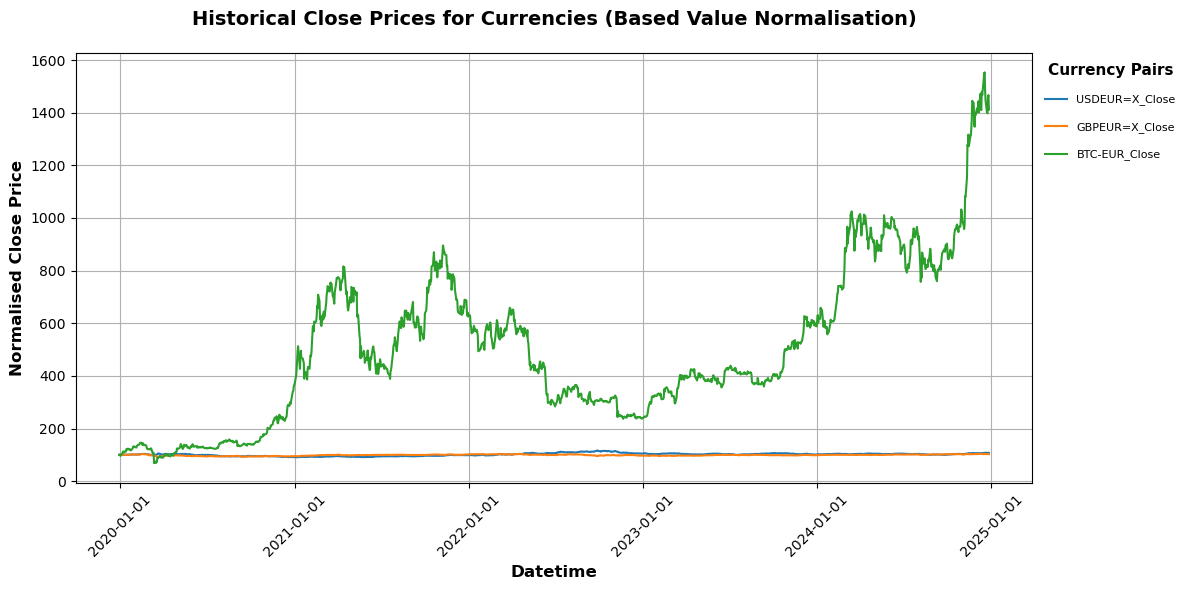

In [28]:
plotClosePrices(normalisedBasedValue5y, title='Historical Close Prices for Currencies (Based Value Normalisation)')

Over the five years, the behaviour of each currency pair gives an interesting insight into their respective trends and volatility since all data was normalized using the same method.
It can be seen from historical data that USDEUR=X_Close (Blue Line) has a quite stable trend line with small fluctuations above or below the base value of 100. In itself, this stability can reflect that over the five years, the exchange rate has been consistent between USD and EUR, with no huge disruptions in the market, which have caused large shifts. It may indicate a certain regularity in the development between the economies of the United States and those within the Eurozone area.

The same trend is shown by the GBPEUR=X_Close, orange line, which reflects a normalized price that has kept almost near the base value of 100. This means the rate of exchange between GBP and EUR has been quite stable between the UK and the Eurozone economies. Of course, slight changes happened, but nothing too extreme; hence, this currency pair was calm during these five years.

On the other hand, BTC-EUR_Close paints a different story altogether. Starting at the base value of 100, the normalized price for BTC-EUR has been very volatile and shows, in general, an upward trend, going over 1600 by the end of the period. This dramatic increase highlights the high volatility and growth potential that Bitcoin offers compared to more traditional fiat currencies. The sharp rise in the value of Bitcoin against the Euro is a reflection of the wider adoption and market fervour for cryptocurrencies, coupled with the high volatility that is characteristic of them.

The above graph succinctly captures that, while the fiat currency pairs are stable and show consistent upward trends in the five years, the BTC-EUR pair has huge growth with high volatility, underlining the different market dynamics between traditional currencies and cryptocurrencies. This plot offers an overall look at how these currency pairs have behaved on an extended timescale and provides a valuable insight into their respective trends and market conditions.